In [1]:
import yaml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize': (15, 9)})

1. What food do we need to bring?
        e.g. trees, seeds, genetically-modified foods
2. How do we feed people there?
        Consider: supply, manage, distribute, connect
7. What are essential key resources?
        e.g. Electricity, oxygen, water, fuel, brick, plastics, steel, food.
4. How do we decide who will go?
        e.g. population proportions, demographics, health, qualifications, genetic diversity
5. What forms of entertainment would people need?
        e.g. music, books, pets, lego
6. What machines do we need?
        e.g. cars, ships, fighter jets, rockets, computers, mobile phones.

- UN Total Population Data
https://population.un.org/wpp/Download/Standard/CSV/
<br>
-

In [2]:
# open fake_countries.yaml file, which contains non-real countries
with open('./data/fake_countries.yaml') as f:
    fake_countries = yaml.safe_load(f)['fake_countries']

# paths to the datasets
fertility_data = './data/WPP2019_Fertility_by_Age.csv'
period_indicator_data = './data/WPP2019_Period_Indicators_Medium.csv'

# load datasets in DataFrames
fertility_df = pd.read_csv(fertility_data)
period_indicator_df = pd.read_csv(period_indicator_data)

In [3]:
# get an insight into the fertility dataset
fertility_df.head()

,LocID,Location,VarID,Variant,Time,MidPeriod,AgeGrp,AgeGrpStart,AgeGrpSpan,ASFR,PASFR,Births
0,4,Afghanistan,2,Medium,1950-1955,1953,15-19,15,5,145.245,9.748,280.906
1,4,Afghanistan,2,Medium,1950-1955,1953,20-24,20,5,313.809,21.061,522.501
2,4,Afghanistan,2,Medium,1950-1955,1953,25-29,25,5,339.005,22.752,481.946
3,4,Afghanistan,2,Medium,1950-1955,1953,30-34,30,5,290.535,19.499,351.097
4,4,Afghanistan,2,Medium,1950-1955,1953,35-39,35,5,233.111,15.645,238.645


[Text(0, 0.5, 'Percentage Age-Specific Fertility Rate'),
 Text(0.5, 0, 'Age Group'),
 Text(0.5, 1.0, 'Fertility Between Age Groups(2020)')]

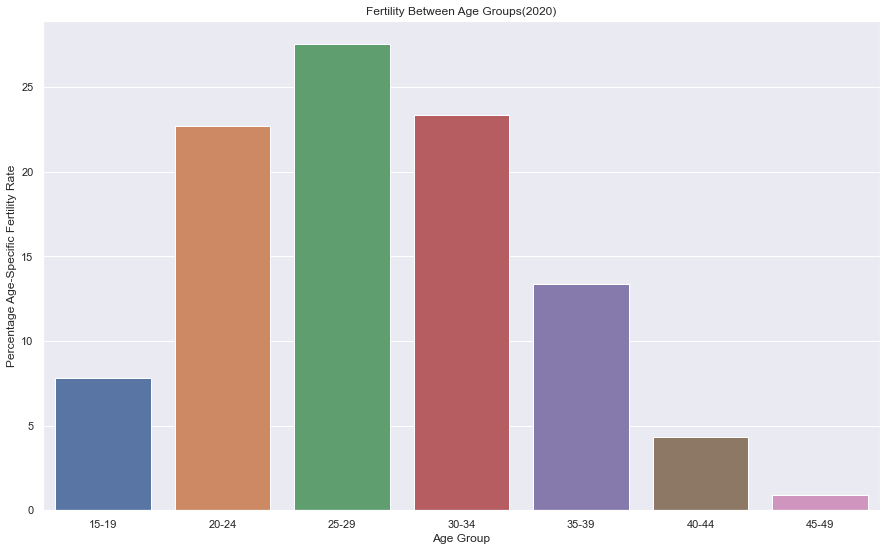

In [4]:
# get all unique age groups
age_groups = fertility_df['AgeGrp'].unique()

# create a new DataFrame of fertility rates for every age group, for 2015-2020
fertility_2018_df = fertility_df.loc[fertility_df['MidPeriod'] == 2018][['PASFR', 'AgeGrp']]

# get the mean PASFR of each age group
avg_br = fertility_2018_df.groupby('AgeGrp')['PASFR'].mean().reset_index()

# plot average fertility rates for each age group
ax = sns.barplot(x='AgeGrp', y='PASFR', data=avg_br)
ax.set(xlabel='Age Group', ylabel='Percentage Age-Specific Fertility Rate', title='Fertility Between Age Groups(2020)')

Most fertile countries: ['Tajikistan', 'Mali', 'United Republic of Tanzania', 'Zambia', 'Mozambique', 'Guinea', 'Senegal', 'Comoros', "Côte d'Ivoire", 'Liberia']


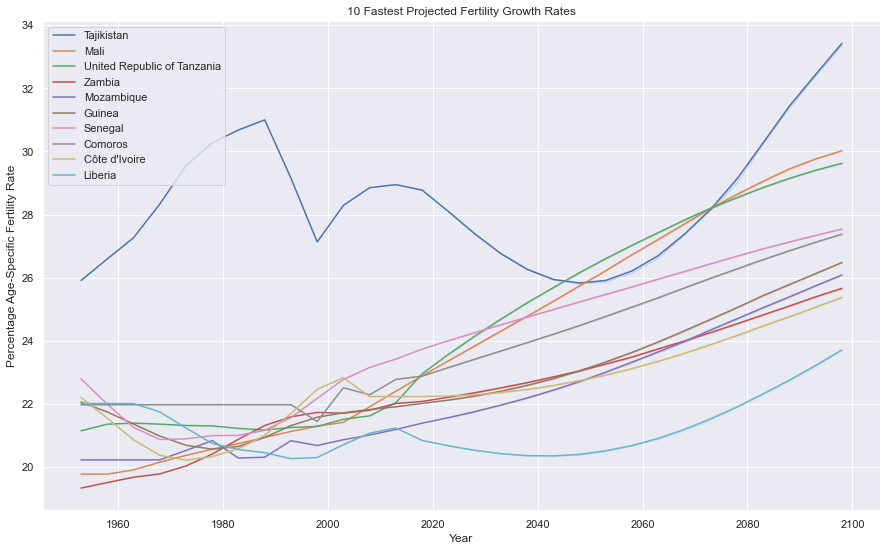

In [5]:
"""
custom aggregation function to find countries with the fastest (projected)
growing fertility rates

:param series: Series object containing PASFR data for each country
"""
def greatest_fertility(series):
    # placeholder values for the lowest, highest, and current fertility rate
    low = float('inf')
    high =  float('-inf')
    current = series.iloc[-1]

    # finds country with highest growing fertility rates
    for pasfr in series:
        if pasfr < low:
            low = pasfr
        elif pasfr > high:
            high = pasfr

    # return value if growth rate is increasing, -inf if growth rate is decreasing
    return (current - low) if high <= current else (float('-inf'))

# Create DataFrame where AgeGrp is 25-29 (the most fertile age group)
fertility_growth_df = fertility_df.loc[fertility_df['AgeGrpStart'] == 25]

# Groups and aggregates values for each country - sorts countries in order of fastest growing fertility rates
fertility_growth_df = fertility_growth_df.reset_index().groupby('Location')[['PASFR']]\
    .agg(greatest_fertility).reset_index().sort_values(by=['PASFR'], ascending=False).set_index('Location')

# drops all fake countries from the DataFrame
fertility_growth_df.drop(fake_countries, inplace=True)

# extract the top 10 fastest growing fertility rates
fertile_10_countries = list(fertility_growth_df.index[:10])
print(f'Most fertile countries: {fertile_10_countries}')

# Creates DataFrame with data of the top 10 fastest growing fertility rate countries
fertile_10_countries_df = fertility_df.loc[(fertility_df['Location'].isin(fertile_10_countries) == True)&(fertility_df['AgeGrpStart']==25)]

# plot
fig, ax = plt.subplots()
for country in fertile_10_countries:
    graph = sns.lineplot(x='MidPeriod', y='PASFR', data=fertile_10_countries_df.loc[fertile_10_countries_df.Location==country], ax=ax, ci=0)
graph.set(xlabel='Year', ylabel='Percentage Age-Specific Fertility Rate', title='10 Fastest Projected Fertility Growth Rates')
ax.legend(fertile_10_countries, loc='upper left')

In [6]:
# set index to the Location column for easy data access
period_indicator_df.set_index('Location', inplace=True)

# drop all fake countries from the dataset
period_indicator_df.drop(fake_countries, inplace=True)

# get an insight into the DataFrame
period_indicator_df

,LocID,VarID,Variant,Time,MidPeriod,TFR,NRR,CBR,Births,LEx,...,CDR,Deaths,DeathsMale,DeathsFemale,CNMR,NetMigrations,GrowthRate,NatIncr,SRB,MAC
Location,,,,,,,,,,,,,,,,,,,,,
Afghanistan,4,2,Medium,1950-1955,1953,7.450,1.636,50.314,2015.476,28.61,...,36.862,1476.605,794.020,682.585,-0.499,-20.0,1.296,13.452,1.060,29.835
Afghanistan,4,2,Medium,1955-1960,1958,7.450,1.765,50.998,2201.589,31.13,...,33.718,1455.605,783.110,672.495,-0.463,-20.0,1.683,17.280,1.060,29.835
Afghanistan,4,2,Medium,1960-1965,1963,7.450,1.899,51.477,2439.130,33.74,...,30.808,1459.784,777.437,682.347,-0.422,-20.0,2.026,20.669,1.060,29.835
Afghanistan,4,2,Medium,1965-1970,1968,7.450,2.017,51.646,2728.221,36.15,...,28.223,1490.896,790.745,700.151,-0.379,-20.0,2.307,23.423,1.060,29.835
Afghanistan,4,2,Medium,1970-1975,1973,7.450,2.141,51.234,3056.451,38.74,...,25.495,1520.938,802.414,718.524,-0.335,-20.0,2.544,25.739,1.060,29.835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe,716,2,Medium,2075-2080,2078,1.913,0.919,14.153,2100.753,72.09,...,9.407,1396.229,729.240,666.989,-0.337,-50.0,0.441,4.746,1.021,29.872
Zimbabwe,716,2,Medium,2080-2085,2083,1.877,0.903,13.429,2030.941,72.73,...,10.001,1512.603,794.805,717.798,-0.331,-50.0,0.310,3.428,1.021,29.984
Zimbabwe,716,2,Medium,2085-2090,2088,1.849,0.891,12.867,1970.518,73.36,...,10.631,1627.991,853.756,774.235,-0.326,-50.0,0.191,2.236,1.021,30.094


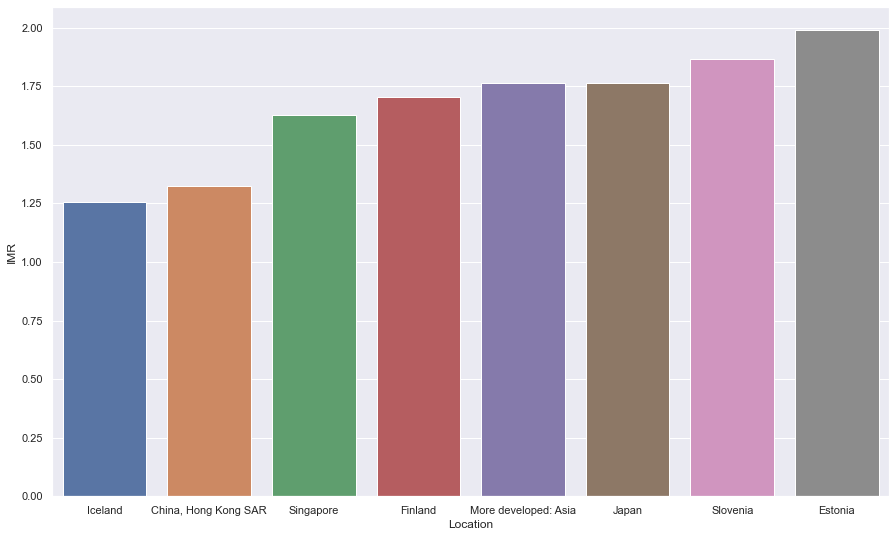

In [7]:
# create DataFrame grouped by country with lowest infant mortality rates
nrr_projected_df = period_indicator_df.loc[period_indicator_df['MidPeriod']==2018].groupby(['Location'])['IMR'].mean()\
    .reset_index().sort_values(by='IMR', ascending=True).reset_index()

# plot countries with lowest IMRs
ax = sns.barplot('Location', 'IMR', data=nrr_projected_df[:8])

In [8]:
"""
function that merges countries with fastest growing fertility rates and countries with lowest IMRs
to get countries with fast growing fertility rates AND low IMRs

:param imr: Countries with lowest IMR
:param fertile: Countries with fastest growing fertility rates
:param num_top: Number of countries to return
"""
def get_top_fertile_imr(imr, fertile, num_top):
    # placeholder list for top countries
    top_countries = []
    imr_i, imr_range = 0, 0
    fertile_i= 0

    # loops through all countries until top_countries list is full
    while len(top_countries) < num_top:
        nrr_range = 0
        top_country = None

        # finds
        for i in range(len(fertile)):
            if imr[imr_i] == fertile[i]:
                top_country = imr[i]
                nrr_range = i
                break

        for i in range(len(imr)):
            if fertile[fertile_i] == imr[i]:
                if i <= nrr_range:
                    top_country = fertile[fertile_i]
                    fertile_i += 1
                else:
                    imr_i += 1

        top_countries.append(top_country)

    return top_countries

top_nrr = nrr_projected_df.set_index('Location').index
top_fertility = fertility_growth_df.index

fertile_nrr_countries = get_top_fertile_imr(list(top_nrr), list(top_fertility), 10)
print(f'Top 9 countries with fertile people, and also low infant mortality: \n{fertile_nrr_countries}')

Top 9 countries with fertile people, and also low infant mortality: 
['Tajikistan', 'ESCAP: ASEAN', 'United Nations Economic Commission for Latin America and the Caribbean (UN-ECLAC)', "Côte d'Ivoire", 'Saudi Arabia', 'Malawi', 'Samoa', 'Mali', 'Mozambique', 'Guinea']


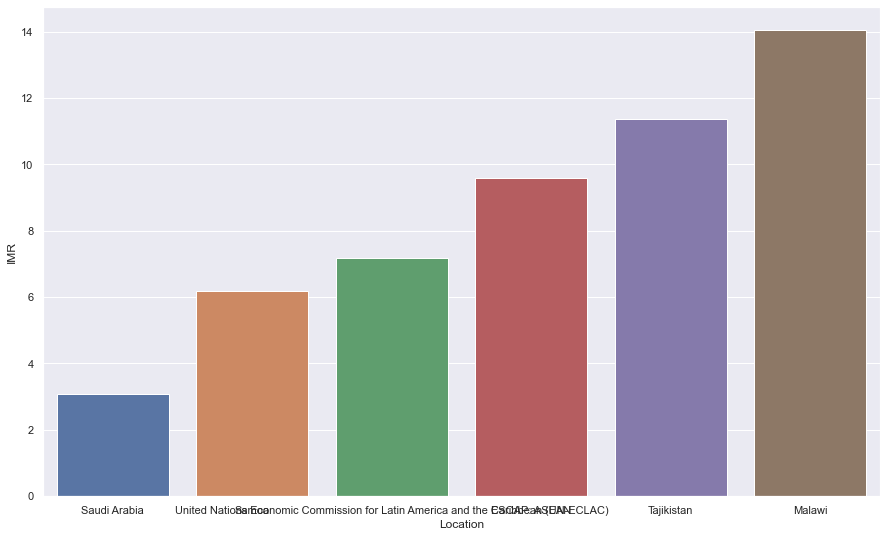

In [9]:
nrr_top10 = period_indicator_df.loc[period_indicator_df['MidPeriod']>=2018].groupby(['Location'])['IMR'].mean()\
    .reset_index().sort_values(by='IMR', ascending=True).reset_index()
ax = sns.barplot('Location', 'IMR', data=nrr_top10.loc[nrr_top10['Location'].isin(fertile_nrr_countries)][:6])